# Credit Card Fraud

Quels facteurs sur les transactions bancaires nous permettent de prédire une fraude à la carte bancaire ?

- EDA
- Preprocessing (ACP, feature selection)
- Modèles :
-* ML supervisé de classification binaire avec régression logistique, RandomForest, (régression linéaire pour les montants) ;
-* ML non supervisé avec clustering géographique DBScan Elbow+Silhouette
- Confrontation des résultats (quel serait le meilleur modèle pour prédire la fraude)
- Exemple de prédiction
- Mise en place du dashboard
- Proposer des questions d'ouverture (pour la présentation)

Si on a le temps : prédire le montant de la fraude (régression linéaire)

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
#pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

In [15]:
data = pd.read_csv('src/fraud test.csv')
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  float64
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [3]:
data['is_fraud'].value_counts()

is_fraud
0    553574
1      2145
Name: count, dtype: int64

In [36]:
2145/(553574+2145)

0.0038598644278853163

In [4]:
data.shape

(555719, 23)

#### Cleansing

In [17]:
def data_cleanse(data_sample):
    '''On retire les colonnes qui ne sont pas pertinentes
        cc_num, trans_num, first, last et {city, state, street, zip} = infos individuelles trop de valeurs différentes
        merchant = idem
        Unnamed: 0 = index, des identifiants donc à supprimer
        unix_time = temps Unix, redondant'''
    colonne_a_retirer = ['cc_num', 'first', 'last', 'city', 'state', 'street', 'zip', 'trans_num', 'Unnamed: 0', 'merchant', 'unix_time', 'lat', 'long']
    df = data_sample.drop(colonne_a_retirer, axis=1)
    df["trans_date_trans_time"]=pd.to_datetime(df["trans_date_trans_time"], format= "%d/%m/%Y %H:%M")
    df["dob"]=pd.to_datetime(df["dob"], format= "%d/%m/%Y")

    annee_actuelle = pd.Timestamp.now().year
    df['age'] = annee_actuelle - df["dob"].dt.year

    df["day_of_the_week"]=df["trans_date_trans_time"].dt.weekday
    df["month"]=df["trans_date_trans_time"].dt.month
    df["day"]=df["trans_date_trans_time"].dt.day
    df["year"]=df["trans_date_trans_time"].dt.year
    df["hour"]=df["trans_date_trans_time"].dt.hour

    colonne_a_retirer = ['trans_date_trans_time', 'dob']
    df = df.drop(colonne_a_retirer, axis=1)
    return df

#### Sample

In [7]:
# Sample en conservant la proportion de is_fraud=0 et de is_fraud=1
data_sample = data.sample(frac=0.1, random_state=0)
print(data_sample['is_fraud'].value_counts())

df = data_cleanse(data_sample)

is_fraud
0    55359
1      213
Name: count, dtype: int64


## Prédiction des fraudes

### Preprocessing

In [43]:
categorical_features = ['category', 'gender']
numerical_features = ['age', 'day', 'month', 'day_of_the_week', 'city_pop', 'merch_lat', 'merch_long']
features = categorical_features + numerical_features
target = 'is_fraud'

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(drop="first"))]
)

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer([
    ('categorical', categorical_transformer, categorical_features),
    ('numerical', numeric_transformer, numerical_features)
])

X = df.loc[:,features]
y = df.loc[:,target]

### Baseline : régression logistique

- En catégorielles on choisit de conserver uniquement la catégorie et le genre.
- En numériques on choisit l'âge, le jour, le mois, le jour de la semaine, la population de la ville, les latitudes et les longitudes de la transaction.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0, stratify=y)

In [53]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [54]:
print("Train model...")
baseline_clf = LogisticRegression(class_weight='balanced', max_iter=1000)
baseline_clf.fit(X_train, y_train)
print("...Done.")

Train model...
...Done.


In [55]:
print("accuracy score on training set : ", baseline_clf.score(X_train, y_train))
print("accuracy score on test set : ", baseline_clf.score(X_test, y_test))

accuracy score on training set :  0.7003341902313625
accuracy score on test set :  0.7036348368522073


In [56]:
y_train_pred = baseline_clf.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.70      0.82     38751
           1       0.01      0.72      0.02       149

    accuracy                           0.70     38900
   macro avg       0.50      0.71      0.42     38900
weighted avg       0.99      0.70      0.82     38900



In [57]:
# Perform 10-fold cross-validation 
print("10-fold cross-validation...")
scores = cross_val_score(baseline_clf, X_train, y_train, cv=10)
print('The cross-validated accuracy is : ', scores.mean())
print('The standard deviation is : ', scores.std())

10-fold cross-validation...
The cross-validated accuracy is :  0.7007455012853471
The standard deviation is :  0.011938902269816308


In [58]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
    if name == 'numerical': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.named_steps['encoder'].get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names

In [59]:
# Create a pandas DataFrame
coefs = pd.DataFrame(index = column_names,
                     data = baseline_clf.coef_.transpose(), 
                     columns=["coefficients"]).sort_values(by='coefficients', key=abs, ascending=False)
coefs

,coefficients
category_misc_net,1.791572
category_grocery_pos,1.779283
category_shopping_net,1.764661
category_health_fitness,-1.709381
category_home,-1.246979
category_personal_care,-1.169552
category_grocery_net,-0.978361
category_gas_transport,0.608970
category_travel,-0.432478
category_shopping_pos,0.395818


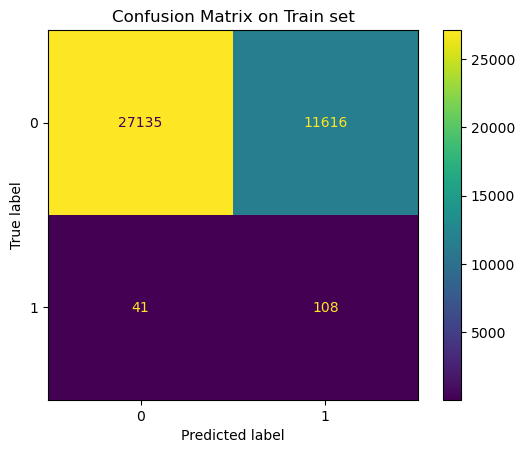

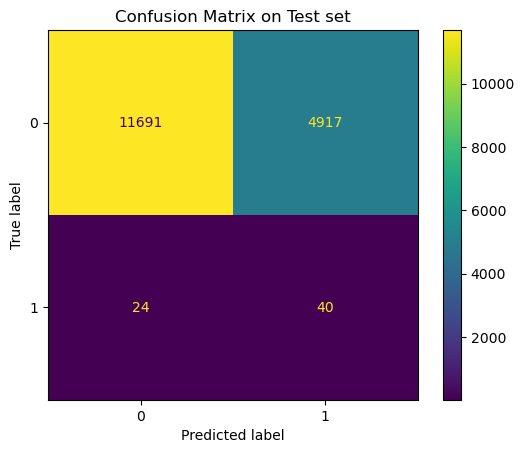

In [60]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(baseline_clf, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(baseline_clf, X_test, y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

Beaucoup trop de faux positifs (precision = 0.01) : il faut réduire le nombre de 0 réels qui sont prédits 1 (4917)

### Model selection evaluation

On reprend les preprocessings du baseline model

#### Random Forest

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0, stratify=y)

In [62]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [63]:
# Perform grid search
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

print("Grid search...")
classifier = RandomForestClassifier(class_weight='balanced')

# Grid of values to be tested
params = {
    "max_depth": [15],
    "min_samples_leaf": [5],
    "min_samples_split": [16],
    "n_estimators": [50],
}
gridsearch = GridSearchCV(
    classifier, param_grid=params, cv=5, scoring='f1'
)  # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation F1-score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 16, 'n_estimators': 50}
Best validation F1-score :  0.07205882352941176


In [64]:
y_train_pred = gridsearch.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38751
           1       0.95      0.97      0.96       149

    accuracy                           1.00     38900
   macro avg       0.97      0.98      0.98     38900
weighted avg       1.00      1.00      1.00     38900



In [65]:
y_test_pred = gridsearch.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16608
           1       0.40      0.03      0.06        64

    accuracy                           1.00     16672
   macro avg       0.70      0.52      0.53     16672
weighted avg       0.99      1.00      0.99     16672



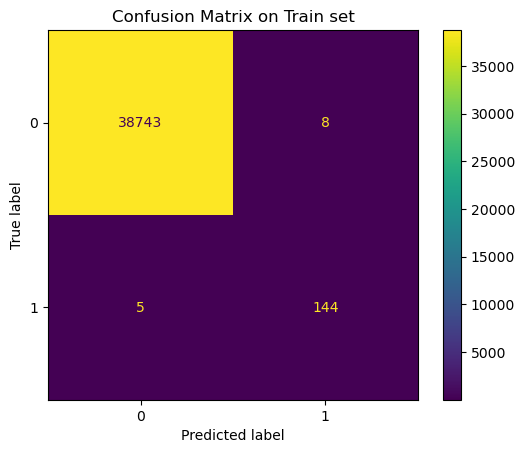

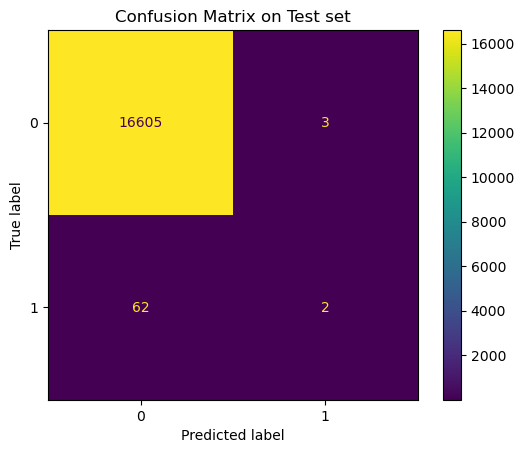

In [66]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

Il y a overfitting => on doit enlever des colonnes qui n'influent pas trop sur le résultat

In [38]:
column_names = []
for (
    name,
    step,
    features_list,
) in preprocessor.transformers_:  # loop over steps of ColumnTransformer
    if name == "num":  # if pipeline is for numeric variables
        features = (
            features_list  # just get the names of columns to which it has been applied
        )
    else:  # if pipeline is for categorical variables
        features = (
            step.get_feature_names_out()
        )  # get output columns names from OneHotEncoder
    column_names.extend(features)  # concatenate features names

# Create a pandas DataFrame
feature_importance = pd.DataFrame(
    index=column_names,
    data=gridsearch.best_estimator_.feature_importances_,
    columns=["feature_importances"],
)
feature_importance = feature_importance.sort_values(by="feature_importances")

# Plot coefficients
fig = px.bar(feature_importance, orientation="h")
fig.update_layout(
    showlegend=False, margin={"l": 120}  # to avoid cropping of column names
)
fig.show()

#### SVM

In [ ]:
svc = SVC(kernel = 'linear', probability = True) # set probability to True if you plan to use predict_proba()
svc.fit(X_train, Y_train)